# Data Preparation

#### Parsing the json **nyc_geo.json** into the dataframe with the following columns:
- Borough
- Neighborhood
- Latitude
- Longitude

In [1]:
import pandas as pd

In [2]:
import json
f = open('nyc_geo.json')
data = json.load(f)

In [3]:
data['features'][0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Bounding Box Waste of time Stuff I did

In [4]:
geo_list = []
for i in data['features']:
    feature_dict = {'borough': i['properties']['borough'],
                    'neighborhood': i['properties']['name'], 
                    'lat': i['geometry']['coordinates'][1],
                    'long': i['geometry']['coordinates'][0],}
                    # 'bbox': i['properties']['bbox']}
    geo_list.append(feature_dict)
    
    
geo_df = pd.DataFrame(geo_list)

geo_df[geo_df.lat > 44]

,borough,neighborhood,lat,long


In [5]:
geo_df.borough.value_counts()

Queens           81
Brooklyn         70
Staten Island    63
Bronx            52
Manhattan        40
Name: borough, dtype: int64

In [6]:
brooklyn = geo_df[geo_df['borough'] == 'Brooklyn']
bronx = geo_df[geo_df['borough'] == 'Bronx']
queens = geo_df[geo_df['borough'] == 'Queens']
staten_island = geo_df[geo_df['borough'] == 'Staten Island']
manhattan = geo_df[geo_df['borough'] == 'Manhattan']

In [7]:
bboxs = {'brooklyn' : [brooklyn.lat.min(), brooklyn.lat.max(), brooklyn.long.min(), brooklyn.long.max()],
         'bronx' : [bronx.lat.min(), bronx.lat.max(), bronx.long.min(), bronx.long.max()],
         'queens' : [queens.lat.min(), queens.lat.max(), queens.long.min(), queens.long.max()],
         'staten_island' : [staten_island.lat.min(), staten_island.lat.max(), staten_island.long.min(), staten_island.long.max()],
         'manhattan' : [manhattan.lat.min(), manhattan.lat.max(), manhattan.long.min(), manhattan.long.max()]
        }

##### The bounding box provided in 'nyc_geo.json' is not sufficient I'm going to parse the data to create a new oe   
---

In [8]:
def make_list(things):
    thing_list = []
    for thing in things:
        thing_list.append(thing)
    return thing_list

In [9]:
boroughs = geo_df.groupby(['borough', 'lat', 'long']).size()

In [10]:
boroughs.Bronx[:5]

lat        long      
40.801664  -73.913221    1
40.806239  -73.916100    1
40.806551  -73.854144    1
40.809730  -73.883315    1
40.815099  -73.895788    1
dtype: int64

In [11]:
def borough_finder(lat, long):
    for i in bboxs:
        if lat > bboxs[i][0] and lat < bboxs[i][1] and long > bboxs[i][2] and long < bboxs[i][3]:
            return i

In [12]:
borough_finder(40.695439, -73.983225)

'brooklyn'

In [13]:
arrest_df['borough'] = arrest_df.apply(lambda x: borough_finder(x.Latitude, x.Longitude), axis=1)

NameError: name 'arrest_df' is not defined

---
#### Using data from NYC_Open_Data website, which contains a variety of informations about NYC boroughs.
<br>
* I have pulled data contaings Arrests, Air Quality, and Evictions reported in the 5 boroughs of NYC in 2022
<br>
<br>
* It may be interesting to find some coorelation between these features
* Perform Clustering
* Apply Data to PowerBI -or- Tableau

---
# EDA, Data Prep and Cleaning

### Starting with exploration the NY arrests dataframe

In [14]:
# load dataframe and take a look at the features
arrest_df = pd.read_csv('NYPD_Arrest_Data__Year_to_Date_.csv')
arrest_df.head(2)

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,238859078,01/09/2022,NaN,(null),NaN,(null),PL 2650022,M,B,49,0,25-44,M,BLACK HISPANIC,1021536,251417,40.856680,-73.865212,POINT (-73.865212 40.85668)
1,239923883,01/31/2022,NaN,(null),NaN,(null),CPL5700600,9,Q,113,3,25-44,M,BLACK,1046367,186986,40.679701,-73.776047,POINT (-73.77604735 40.67970059)


Dropping unnecessary Columns from arrest dataframe

In [15]:
#### Dropping Unnessesary Columns from arrest dataframe
arrest_df.drop(['ARREST_KEY', 'PD_CD','PD_DESC',  'KY_CD', 'LAW_CODE', 'ARREST_PRECINCT', 'JURISDICTION_CODE', 'X_COORD_CD', 'Y_COORD_CD', 'New Georeferenced Column'], axis=1, inplace=True)

In [16]:
arrest_df.head(5)

,ARREST_DATE,OFNS_DESC,LAW_CAT_CD,ARREST_BORO,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude
0,01/09/2022,(null),M,B,25-44,M,BLACK HISPANIC,40.856680,-73.865212
1,01/31/2022,(null),9,Q,25-44,M,BLACK,40.679701,-73.776047
2,01/25/2022,RAPE,F,K,25-44,M,BLACK,40.664121,-73.947765
3,03/03/2022,RAPE,F,K,18-24,M,BLACK,40.695439,-73.983225
4,02/22/2022,RAPE,F,B,45-64,M,BLACK,40.816206,-73.896001


In [17]:
arrest_df.ARREST_BORO.replace({'B': 'Bronx',
                  'S': 'Staten Island',
                  'K': 'Brooklyn',
                  'M': 'Manhattan',
                  'Q': 'Queens'}, inplace=True)

arrest_df.LAW_CAT_CD.replace({'M': 'Misdemeanor',
                  'F': 'Felony',
                  'V': 'Violation',
                  '9': None,
                  'I': None}, inplace=True)

In [18]:
arrest_df.LAW_CAT_CD.value_counts()

Misdemeanor    74915
Felony         63227
Violation        539
Name: LAW_CAT_CD, dtype: int64

---
#### Handling Null Values

In [19]:
arrest_df.isnull().sum()

ARREST_DATE       0
OFNS_DESC         0
LAW_CAT_CD     1883
ARREST_BORO       0
AGE_GROUP         0
PERP_SEX          0
PERP_RACE         0
Latitude          0
Longitude         0
dtype: int64

In [20]:
arrest_df.OFNS_DESC.replace({'(null)': None}, inplace=True)
arrest_df.dropna(inplace=True)

In [21]:
arrest_df.dtypes # convert date column to datetime format

ARREST_DATE     object
OFNS_DESC       object
LAW_CAT_CD      object
ARREST_BORO     object
AGE_GROUP       object
PERP_SEX        object
PERP_RACE       object
Latitude       float64
Longitude      float64
dtype: object

In [22]:
arrest_df.head(2)

,ARREST_DATE,OFNS_DESC,LAW_CAT_CD,ARREST_BORO,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude
2,01/25/2022,RAPE,Felony,Brooklyn,25-44,M,BLACK,40.664121,-73.947765
3,03/03/2022,RAPE,Felony,Brooklyn,18-24,M,BLACK,40.695439,-73.983225


In [24]:
# pd.to_datetime('ARREST_DATE')

In [26]:
arrest_df['ARREST_DATE'] = pd.to_datetime(arrest_df['ARREST_DATE'])

In [27]:
arrest_df.dtypes

ARREST_DATE    datetime64[ns]
OFNS_DESC              object
LAW_CAT_CD             object
ARREST_BORO            object
AGE_GROUP              object
PERP_SEX               object
PERP_RACE              object
Latitude              float64
Longitude             float64
dtype: object

---
ideas <br>
* Test Distrubution of all Features
* Compare Corelations betweens features, (heatmap, scatter plot, PCA)
* make cool plots 
<br>
----
Feature Engineering<br>
* Repeat Offender
* Was is a Holiday?
* Was it a weekend or weekday(binary)
* Air Pollution in that area
* Holiday?
* Evictions within that Area 


it works!

---
# Data Visualization

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

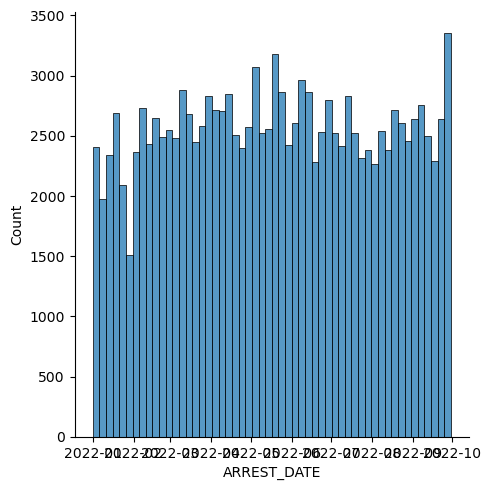

In [31]:
sns.displot(arrest_df.ARREST_DATE)
plt.show()